Loading CSV file: box.csv
0
100.0
399
100.0
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-26
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 400 rows, 1522 columns and 3042 nonzeros
Model fingerprint: 0xe86f6701
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 2 rows and 4 columns
Presolve time: 0.00s
Presolved: 398 rows, 1518 columns, 3034 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+02   1.000000e+02   0.000000e+00      0s
     165    2.6000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 165 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.600000000e+01


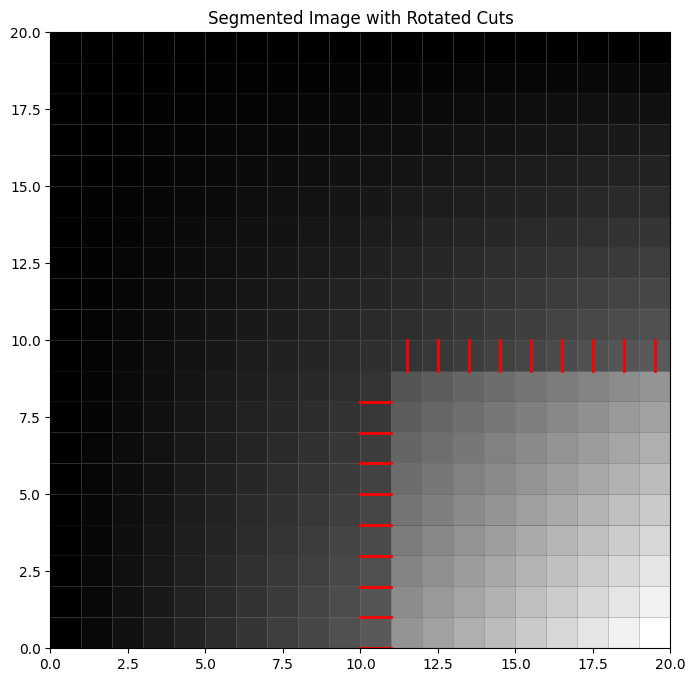

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
from PIL import Image
# Function to calculate similarity between two pixels
def calculate_similarity(I_i, I_j, sigma):
    return np.ceil(100 * np.exp(-((I_i - I_j) ** 2) / (2 * sigma ** 2)))
# Function to construct the network using only neighboring pixels
def construct_and_solve_network_sparse(pixel_values, background_pixel, foreground_pixel, sigma):
    rows, cols = pixel_values.shape
    num_pixels = rows * cols
    # Create an empty dictionary to store the neighboring pixel connections
    network = {}
    # Flatten the pixel array for easier indexing
    pixel_values_flat = pixel_values.flatten()
    # Build the network by adding edges only between neighboring pixels (up, down, left, right)
    for r in range(rows):
        for c in range(cols):
            current_pixel = r * cols + c
            neighbors = []
            # Connect to right neighbor
            if c + 1 < cols:
                right_neighbor = r * cols + (c + 1)
                similarity = calculate_similarity(pixel_values_flat[current_pixel], pixel_values_flat[right_neighbor], sigma)
                network[(current_pixel, right_neighbor)] = similarity
                network[(right_neighbor, current_pixel)] = similarity  # Symmetric edge
            # Connect to bottom neighbor
            if r + 1 < rows:
                bottom_neighbor = (r + 1) * cols + c
                similarity = calculate_similarity(pixel_values_flat[current_pixel], pixel_values_flat[bottom_neighbor], sigma)
                network[(current_pixel, bottom_neighbor)] = similarity
                network[(bottom_neighbor, current_pixel)] = similarity  # Symmetric edge

    # Add source (node N) and sink (node N+1) to the network
    source = num_pixels  # Source is node N
    sink = num_pixels + 1  # Sink is node N+1

    # Connect source to the background pixel
    background_pixel_index = background_pixel[0] * cols + background_pixel[1]
    print(background_pixel_index)
    network[(source, background_pixel_index)] = max(network.values())
    print(network[(source, background_pixel_index)])
    # Connect sink to the foreground pixel
    foreground_pixel_index = foreground_pixel[0] * cols + foreground_pixel[1]
    print(foreground_pixel_index)
    network[(foreground_pixel_index, sink)] = max(network.values())
    print(network[(foreground_pixel_index, sink)])

    # Step 4: Formulate the LP using Gurobi
    mod = gp.Model()
    # Add flow variables for only the edges that exist in the network (sparse matrix)
    flow_vars = {}
    for (i, j) in network:
        flow_vars[(i, j)] = mod.addVar(lb=0, ub=network[(i, j)], name=f"flow_{i}_{j}")
    # Objective: Maximize flow from the source to the sink
    mod.setObjective(flow_vars[(source, background_pixel_index)], GRB.MAXIMIZE)
    # Flow conservation constraints for every pixel except source and sink
    for pixel in range(num_pixels):
        inflow = gp.quicksum(flow_vars[(j, pixel)] for j in range(num_pixels + 2) if (j, pixel) in flow_vars)
        outflow = gp.quicksum(flow_vars[(pixel, j)] for j in range(num_pixels + 2) if (pixel, j) in flow_vars)
        mod.addConstr(inflow == outflow, f"flow_conservation_{pixel}")
    # Optimize the model
    mod.optimize()
    # Step 5: Solve the LP and Find the Min Cut
    if mod.status == GRB.OPTIMAL:
        flows = {key: var.x for key, var in flow_vars.items()}
        # Calculate the residual network (capacity - flow)
        residual_network = {key: network[key] - flows[key] for key in flows}
        # Perform DFS from the source to find all accessible nodes in the residual network
        def dfs(node, visited, residual_network):
            visited.add(node)
            for (i, j) in residual_network:
                if i == node and j not in visited and residual_network[(i, j)] > 0:
                    dfs(j, visited, residual_network)
        visited_from_source = set()
        dfs(source, visited_from_source, residual_network)
        # Identify the cut: edges between accessible and non-accessible nodes
        cut_edges = []
        inaccessible_nodes = set(range(num_pixels + 2)) - visited_from_source
        for (i, j) in network:
            if i in visited_from_source and j in inaccessible_nodes:
                cut_edges.append((i, j))
        return cut_edges, num_pixels
    return None, None
# Function to visualize the results
# Function to visualize the results with a 90-degree rotation for red cuts
def visualize_results(pixel_values, cut_edges, network_size):
    rows, cols = pixel_values.shape
    num_pixels = rows * cols
    # Display the original image with pixel intensity values
    plt.figure(figsize=(8, 8))
    plt.pcolor(pixel_values[::-1], cmap='gray', edgecolors='k', linewidths=0.1)  # Flip the image to correct orientation
    # Draw the cuts in red with a 90-degree rotation
    for node, neighbor in cut_edges:
        if node < num_pixels and neighbor < num_pixels:  # Ignore source/sink
            r1, c1 = divmod(node, cols)
            r2, c2 = divmod(neighbor, cols)
            # Vertical cut (now becomes horizontal after rotation): Draw between columns
            if abs(c1 - c2) == 1:
                # Draw a horizontal line between c1 and c2 (rotated)
                plt.plot([c1, c1 + 1], [rows - r1 - 1, rows - r1 - 1], color='red', linewidth=2)
            # Horizontal cut (now becomes vertical after rotation): Draw between rows
            elif abs(r1 - r2) == 1:
                # Draw a vertical line between r1 and r2 (rotated)
                plt.plot([c1 + 0.5, c1 + 0.5], [rows - r1, rows - r1 - 1], color='red', linewidth=2)
    plt.title('Segmented Image with Rotated Cuts')
    plt.show()
# Main function to run the process
def main():
    # Prompt user for inputs
    file_path = input("Enter the file path (image or CSV): ")
    # Get background and foreground pixels from user
    background_x = int(input("Enter the x-coordinate of the background pixel: "))
    background_y = int(input("Enter the y-coordinate of the background pixel: "))
    foreground_x = int(input("Enter the x-coordinate of the foreground pixel: "))
    foreground_y = int(input("Enter the y-coordinate of the foreground pixel: "))
    # Get sigma value from user
    sigma = float(input("Enter the sigma value for similarity calculation: "))
    def load_image_or_csv(filepath):
        if filepath.endswith('.csv'):
            print(f"Loading CSV file: {filepath}")
            data = pd.read_csv(filepath, header=None)
            return data.to_numpy()
        else:
            print(f"Loading image file: {filepath}")
            img = Image.open(filepath).convert('L')  # Convert to grayscale
            return np.array(img)
    # Load the image or CSV file (intensity values)
    pixel_values = load_image_or_csv(file_path)
    # Set background and foreground pixels from user input
    background_pixel = (background_y, background_x)
    foreground_pixel = (foreground_y, foreground_x)
    # Step 2: Construct the network and solve the max flow problem using sparse representation
    cut_edges, network_size = construct_and_solve_network_sparse(pixel_values, background_pixel, foreground_pixel, sigma)
    if cut_edges is not None:
        # Step 3: Visualize the results
        visualize_results(pixel_values, cut_edges, network_size)
if __name__ == "__main__":
    main()

